In [3]:
import os

import GCRCatalogs
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from GCRCatalogs import GCRQuery
from GCRCatalogs.helpers.tract_catalogs import tract_filter

GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")

We specify the path at which we'll save the pkl file:

In [2]:
file_name = "dc2_lensing_catalog.pkl"
file_path = os.path.join("/data", "scratch", "dc2local", file_name)
file_already_populated = os.path.isfile(file_path)

---

### Truth

We load in the truth catalog and list all available quantities:

In [3]:
truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_truth")

In [4]:
truth_cat.list_all_quantities()

['mag_r',
 'dec',
 'id_string',
 'host_galaxy',
 'is_good_match',
 'tract',
 'cosmodc2_hp',
 'flux_z',
 'cosmodc2_id',
 'is_unique_truth_entry',
 'mag_z',
 'ra',
 'is_nearest_neighbor',
 'mag_u',
 'patch',
 'truth_type',
 'match_sep',
 'match_objectId',
 'mag_y',
 'av',
 'flux_g',
 'id',
 'mag_g',
 'flux_r',
 'rv',
 'flux_i',
 'flux_u',
 'redshift',
 'flux_y',
 'mag_i']

And we fetch the variables we want. DC2 images are only available for tracts 3828 and 3829, so we'll load in the catalog for those two tracts and the tracts that surround them (see [here](https://arxiv.org/pdf/2101.04855)).

In [5]:
truth_df = truth_cat.get_quantities(
    quantities=[
        "cosmodc2_id",
        "id",
        "match_objectId",
        "tract",
        "is_unique_truth_entry",
        "truth_type",
        "ra",
        "dec",
        "redshift",
        "flux_u",
        "flux_g",
        "flux_r",
        "flux_i",
        "flux_z",
        "flux_y",
        "mag_u",
        "mag_g",
        "mag_r",
        "mag_i",
        "mag_z",
        "mag_y",
    ],
    native_filters=[tract_filter([3634, 3635, 3636, 3827, 3828, 3829, 3830, 4025, 4026, 4027])],
)

truth_df = pd.DataFrame(truth_df)

We see that there are around 47 million objects in the truth table:

In [6]:
truth_df.shape

(47003941, 21)

A small number of these objects are stars or supernovae rather than galaxies, so we filter those out:

In [7]:
truth_df = truth_df[truth_df["truth_type"] == 1]

In [8]:
truth_df.shape

(46707830, 21)

We create an ra/dec filter that we'll apply to CosmoDC2, as well as an equivalent (but faster) healpix filter:

In [9]:
max_ra = np.nanmax(truth_df["ra"])
min_ra = np.nanmin(truth_df["ra"])
max_dec = np.nanmax(truth_df["dec"])
min_dec = np.nanmin(truth_df["dec"])
ra_dec_filters = [f"ra >= {min_ra}", f"ra <= {max_ra}", f"dec >= {min_dec}", f"dec <= {max_dec}"]

In [10]:
vertices = hp.ang2vec(
    np.array([min_ra, max_ra, max_ra, min_ra]),
    np.array([min_dec, min_dec, max_dec, max_dec]),
    lonlat=True,
)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

Here are the ID variables in the truth table:

In [11]:
truth_df[["cosmodc2_id", "id", "match_objectId"]]

,cosmodc2_id,id,match_objectId
0,8757401501,8757401501,15982501021353368
1,8750694182,8750694182,15982501021353393
2,8752812073,8752812073,15982501021353397
3,8750045581,8750045581,15982501021353414
4,8751841300,8751841300,15982501021353419
...,...,...,...
47003936,7883881935,7883881935,-1
47003937,7883590905,7883590905,-1
47003938,7881519644,7881519644,-1
47003939,7881928305,7881928305,-1


We see that `id` and `cosmodc2_id` are equivalent, at least for galaxies:

In [12]:
(truth_df["cosmodc2_id"] == truth_df["id"]).mean()

1.0

All of the galaxies are unique:

In [13]:
truth_df["is_unique_truth_entry"].mean()

1.0

Approximately 35.9 galaxies are not matched in the object table (e.g., because they are blended or faint). The remaining 10.8 million are matched:

In [14]:
print((truth_df["match_objectId"] == -1).sum())
print((truth_df["match_objectId"] > -1).sum())

35896802
10811028


### Object-with-truth–match

We load in the object-with-truth-match catalog and list all available quantities:

In [15]:
object_truth_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")

In [16]:
object_truth_cat.list_all_quantities()

['Ixy_pixel_u',
 'psFlux_flag_y',
 'cModelFlux_z',
 'dec_truth',
 'Ixx_pixel_g',
 'IxyPSF_pixel_z',
 'psFluxErr_u',
 'Ixy_pixel_r',
 'psFluxErr_r',
 'snr_i_cModel',
 'cModelFlux_flag_i',
 'Iyy_pixel_r',
 'xy_flag',
 'IxxPSF_pixel_y',
 'IxyPSF_pixel_r',
 'IyyPSF_pixel_r',
 'mag_u_truth',
 'psFlux_flag_i',
 'IyyPSF_pixel_u',
 'Ixy_pixel_y',
 'av_truth',
 'psFlux_flag_u',
 'cModelFlux_g',
 'mag_g_truth',
 'Ixy_pixel_z',
 'IxxPSF_pixel_r',
 'psNdata',
 'Ixx_pixel_i',
 'Ixx_pixel_r',
 'snr_r_cModel',
 'IxxPSF_pixel',
 'mag_i_cModel',
 'cModelFlux_u',
 'tract_truth',
 'psFluxErr_i',
 'magerr_z',
 'mag_r_truth',
 'good',
 'magerr_i_cModel',
 'mag_z',
 'xErr',
 'flux_y_truth',
 'is_unique_truth_entry',
 'psFlux_flag_z',
 'cModelFlux_i',
 'psf_fwhm_z',
 'magerr_r_cModel',
 'extendedness',
 'mag_r_cModel',
 'flux_r_truth',
 'magerr_g',
 'magerr_y_cModel',
 'IxyPSF_pixel_i',
 'cModelFluxErr_i',
 'tract',
 'magerr_z_cModel',
 'Ixx_pixel_y',
 'Ixy_pixel_i',
 'cModelFlux_y',
 'mag_z_truth',
 'match_

And we fetch the variables we want:

In [17]:
object_truth_df = object_truth_cat.get_quantities(
    quantities=[
        "cosmodc2_id_truth",
        "Ixx_pixel",
        "Iyy_pixel",
        "Ixy_pixel",
        "IxxPSF_pixel_u",
        "IxxPSF_pixel_g",
        "IxxPSF_pixel_r",
        "IxxPSF_pixel_i",
        "IxxPSF_pixel_z",
        "IxxPSF_pixel_y",
        "IyyPSF_pixel_u",
        "IyyPSF_pixel_g",
        "IyyPSF_pixel_r",
        "IyyPSF_pixel_i",
        "IyyPSF_pixel_z",
        "IyyPSF_pixel_y",
        "IxyPSF_pixel_u",
        "IxyPSF_pixel_g",
        "IxyPSF_pixel_r",
        "IxyPSF_pixel_i",
        "IxyPSF_pixel_z",
        "IxyPSF_pixel_y",
        "psf_fwhm_u",
        "psf_fwhm_g",
        "psf_fwhm_r",
        "psf_fwhm_i",
        "psf_fwhm_z",
        "psf_fwhm_y",
    ],
    filters=ra_dec_filters,
    native_filters=[tract_filter([3634, 3635, 3636, 3827, 3828, 3829, 3830, 4025, 4026, 4027])],
)

object_truth_df = pd.DataFrame(object_truth_df)

We see that there are around 11 million objects in the object-truth table:

In [18]:
object_truth_df.shape

(11116206, 28)

We don't need to explicitly filter out stars, supernovae, and faint galaxies as we did above, as this will happen implicitly when we merge `object_truth_df` with `truth_df`.

---

### CosmoDC2

Next, we load in CosmoDC2 and list all available quantities:

In [ ]:
config_overwrite = {"catalog_root_dir": "/data/scratch/dc2_nfs/cosmoDC2_v1.1.4"}

cosmo_cat = GCRCatalogs.load_catalog("desc_cosmodc2", config_overwrite)

In [20]:
cosmo_cat.list_all_quantities()

['sed_1933_474_disk',
 'sed_2998_186_bulge',
 'size_minor_true',
 'sed_6954_431_bulge_no_host_extinction',
 'sed_4299_266_disk',
 'sed_4848_300_disk_no_host_extinction',
 'sed_8846_549_bulge',
 'sed_2998_186_disk',
 'sed_4048_251',
 'stellar_mass_disk',
 'Mag_true_g_sdss_z0',
 'mag_i_sdss_no_host_extinction',
 'Mag_true_i_sdss_z0',
 'sed_3812_236_disk',
 'Mag_true_i_lsst_z0',
 'sed_9395_583_disk_no_host_extinction',
 'mag_true_g',
 'sed_4565_283_bulge',
 'ra_true',
 'sed_1246_306_disk_no_host_extinction',
 'sersic_bulge',
 'sed_13177_1966',
 'sed_6548_406_disk_no_host_extinction',
 'mag_z_sdss_no_host_extinction',
 'sed_3381_209_no_host_extinction',
 'sed_11467_1710_bulge',
 'sed_1246_306',
 'mag_y_lsst_no_host_extinction',
 'sed_3381_209_bulge',
 'sed_6166_382_disk',
 'sed_2998_186_disk_no_host_extinction',
 'sed_1933_474',
 'sed_7843_486_bulge_no_host_extinction',
 'sed_4848_300_no_host_extinction',
 'mag_u_lsst',
 'sed_8329_517_disk',
 'halo_mass',
 'sed_6166_382',
 'position_y',
 '

And we fetch the variables we want.

Some notes:
- We only pull objects in the ra/dec region from the truth table, using the filters defined above.
- ellipticity_1_true_dc2 and ellipticity_2_true_dc2 are the unlensed ellipticities that were used in the DC2 images (i.e., shear and convergence were applied to these ellipticities). ellipticity_1_true and ellipticity_2_true are the unlensed ellipticities from a subsequent bug fix described in section 2.4 of [this paper](https://arxiv.org/pdf/2101.04855). Ideally we'd want the lensed versions ellipticity_1 and ellipticity_2, which are listed [here](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md) but are not available (see the above list).

In [21]:
cosmo_df = cosmo_cat.get_quantities(
    quantities=[
        "galaxy_id",
        "ra",
        "dec",
        "ellipticity_1_true",
        "ellipticity_2_true",
        "ellipticity_1_true_dc2",
        "ellipticity_2_true_dc2",
        "shear_1",
        "shear_2",
        "convergence",
    ],
    filters=ra_dec_filters,
    native_filters=healpix_filter,
)
cosmo_df = pd.DataFrame(cosmo_df)

We see that there are around 135 million galaxies in CosmoDC2:

In [22]:
cosmo_df.shape

(134746624, 10)

---

### Merge `truth_df` and `object_truth_df`

We merge the truth table with the object-with-truth-match table using CosmoDC2 ID:

In [23]:
merge_df1 = truth_df.merge(
    object_truth_df, left_on="cosmodc2_id", right_on="cosmodc2_id_truth", how="left"
)

We remove duplicate `cosmodc2_id`s. These arise because a small number of measured objects in `object_truth_df` are matched with the same `cosmodc2_id` in the truth table. But the only columns of `object_truth_df` that we are using are the `_truth` columns, so our merged data frame has the same truth values listed multiple times (as opposed to slighly different measured values corresponding to the multiple objects that were matched to the same `cosmodc2_id`).

In [24]:
merge_df1.drop_duplicates(subset=["cosmodc2_id"], inplace=True)

Now `merge_df1` has the same number of rows as `truth_df`, as expected:

In [25]:
merge_df1.shape

(46707830, 49)

We drop `cosmodc2_id_truth` since it's not needed anymore:

In [26]:
merge_df1.drop(columns=["cosmodc2_id_truth"], inplace=True)

---

### Merge `merge_df1` and `cosmo_df`

And now we merge the above data frame with CosmoDC2, again using CosmoDC2 ID (which is called `galaxy_id` in `cosmo_df`):

In [27]:
merge_df2 = merge_df1.merge(cosmo_df, left_on="cosmodc2_id", right_on="galaxy_id", how="left")

As expected, the new data frame has the same number of rows as `merge_df1`:

In [28]:
merge_df2.shape

(46707830, 58)

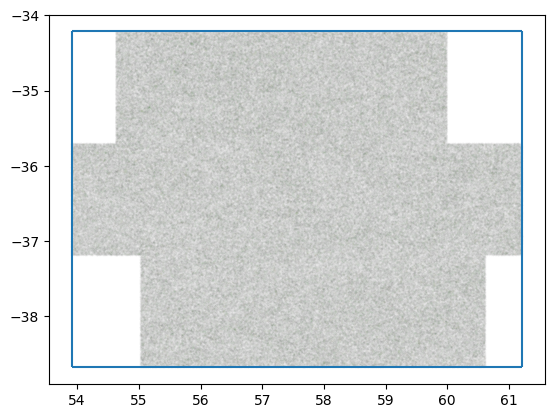

In [29]:
merge_df2_subset = merge_df2.sample(1000000)
_ = plt.scatter(
    merge_df2_subset["ra_x"],
    merge_df2_subset["dec_x"],
    c=merge_df2_subset["redshift"],
    alpha=0.005,
    s=1,
)
_ = plt.vlines(x=[min_ra, max_ra], ymin=max_dec, ymax=min_dec)
_ = plt.hlines(y=[min_dec, max_dec], xmin=min_ra, xmax=max_ra)

Here is the distribution of magnitude by bin:

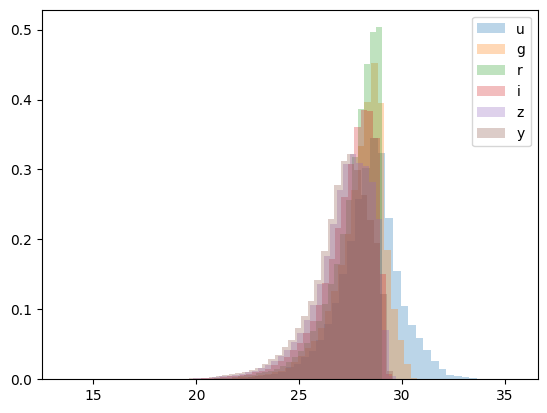

In [30]:
_ = plt.hist(merge_df2_subset["mag_u"], bins=50, alpha=0.3, density=True, label="u")
_ = plt.hist(merge_df2_subset["mag_g"], bins=50, alpha=0.3, density=True, label="g")
_ = plt.hist(merge_df2_subset["mag_r"], bins=50, alpha=0.3, density=True, label="r")
_ = plt.hist(merge_df2_subset["mag_i"], bins=50, alpha=0.3, density=True, label="i")
_ = plt.hist(merge_df2_subset["mag_z"], bins=50, alpha=0.3, density=True, label="z")
_ = plt.hist(merge_df2_subset["mag_y"], bins=50, alpha=0.3, density=True, label="y")
_ = plt.legend()

Here's the distribution of redshift by bin:

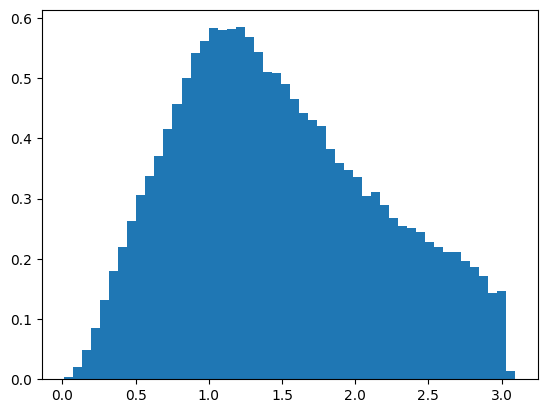

In [31]:
_ = plt.hist(merge_df2_subset["redshift"], density=True, bins=50)

We compute the [0, 0.25, 0.5, 0.75, and 1.0] redshift quantiles among galaxies in the object-with-truth-match table (i.e., those with `match_objectId` > -1). In doing so, we emulate the tomogrphic bins that would be used for catalog-based weak lensing analyses on DC2. These quantiles will be the bin thresholds for our inference procedure.

In [32]:
merge_df2["redshift"][merge_df2["match_objectId"] > -1].quantile([0.0, 0.25, 0.5, 0.75, 1.0])

0.00    0.006692
0.25    0.762988
0.50    1.120420
0.75    1.592735
1.00    3.123174
Name: redshift, dtype: float64

And now we can examine shear and convergence, which were initially in `cosmo_df`:

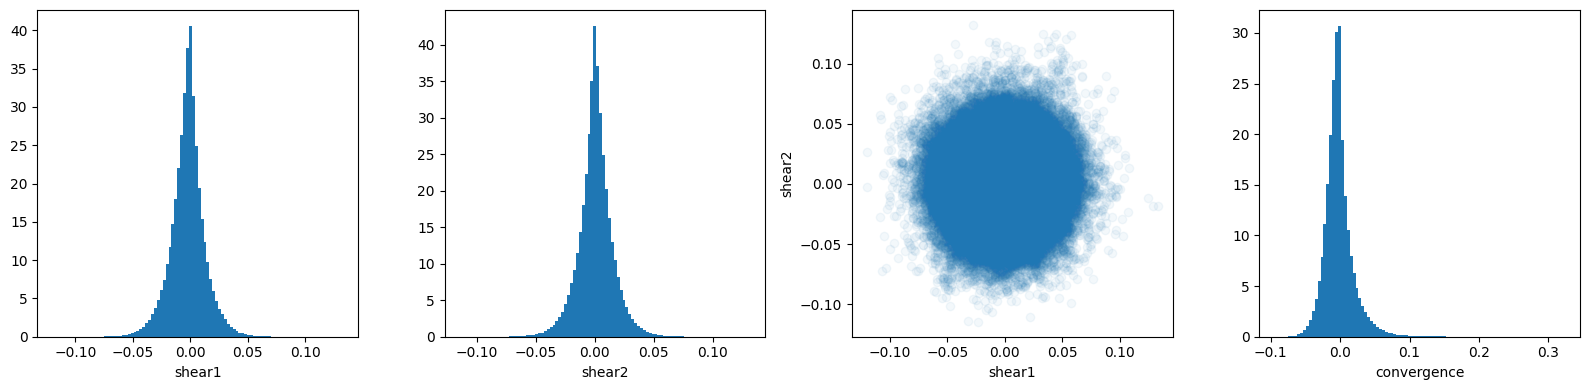

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
_ = ax[0].hist(merge_df2_subset["shear_1"], density=True, bins=100)
_ = ax[0].set_xlabel("shear1")
_ = ax[1].hist(merge_df2_subset["shear_2"], density=True, bins=100)
_ = ax[1].set_xlabel("shear2")
_ = ax[2].scatter(merge_df2_subset["shear_1"], merge_df2_subset["shear_2"], alpha=0.05)
_ = ax[2].set_xlabel("shear1")
_ = ax[2].set_ylabel("shear2")
_ = ax[3].hist(merge_df2_subset["convergence"], density=True, bins=100)
_ = ax[3].set_xlabel("convergence")
fig.tight_layout()

We remove `ra_y` and `dec_y` since they're the same as `ra_x` and `dec_x`, respectively:

In [35]:
merge_df2.drop(columns=["ra_y", "dec_y"], inplace=True)

And then we rename `ra_x` and `dec_x` to `ra` and `dec`, respectively:

In [36]:
merge_df2.rename(columns={"ra_x": "ra", "dec_x": "dec"}, inplace=True)

---

Finally, we save `merge_df2` to `file_path`:

In [37]:
# with open(file_path, "wb") as f:
#     pkl.dump(merge_df2, f)